# Imports

In [1]:
import requests
import json
import pandas as pd

# Definitions

In [2]:
leagueID = "1041760"
fpl_league_url = (
    f"https://fantasy.premierleague.com/api/leagues-classic/{leagueID}/standings/"
)
all_gws_url_template = (
    "https://fantasy.premierleague.com/api/entry/{manager_id}/history/"
)

# Testing

## Connect

In [3]:
respose = requests.get(fpl_league_url)
if respose.status_code == 200:
    print("The API request was successful.")
    fpl_league_respose_json = respose.json()
else:
    print(f"Error: The API request failed with status code {respose.status_code}.")

The API request was successful.


## Parse respose_json

In [4]:
fpl_league_respose_json

{'new_entries': {'has_next': False, 'page': 1, 'results': []},
 'last_updated_data': '2023-12-17T21:10:50Z',
 'league': {'id': 1041760,
  'name': 'MNF',
  'created': '2023-08-07T09:06:50.015343Z',
  'closed': False,
  'max_entries': None,
  'league_type': 'x',
  'scoring': 'c',
  'admin_entry': 4651100,
  'start_event': 1,
  'code_privacy': 'p',
  'has_cup': True,
  'cup_league': None,
  'rank': None},
 'standings': {'has_next': False,
  'page': 1,
  'results': [{'id': 35939248,
    'event_total': 68,
    'player_name': 'Alex Winn',
    'rank': 1,
    'last_rank': 2,
    'rank_sort': 1,
    'total': 995,
    'entry': 3794145,
    'entry_name': 'Al-Winn'},
   {'id': 35832424,
    'event_total': 60,
    'player_name': 'James Parfitt',
    'rank': 2,
    'last_rank': 3,
    'rank_sort': 2,
    'total': 985,
    'entry': 4651100,
    'entry_name': 'Parf 2.8'},
   {'id': 57395169,
    'event_total': 43,
    'player_name': 'Mason Gardener',
    'rank': 3,
    'last_rank': 1,
    'rank_sort':

In [5]:
league_df = pd.DataFrame(fpl_league_respose_json["standings"]["results"])
league_df

,id,event_total,player_name,rank,last_rank,rank_sort,total,entry,entry_name
0,35939248,68,Alex Winn,1,2,1,995,3794145,Al-Winn
1,35832424,60,James Parfitt,2,3,2,985,4651100,Parf 2.8
2,57395169,43,Mason Gardener,3,1,3,977,6963106,nice to Michu
3,58581266,67,Seb Winn,4,4,4,974,7052472,Gangsters Allardyce
4,56846765,37,Richard Collins,5,5,5,929,6911033,Eze-er said than Son
5,35832433,67,Ben Melhuish,6,8,6,919,4075412,Melshys Mediocres
6,35879230,55,Joseph Parsons,7,6,7,911,4656770,AFC Great Name UTD
7,35832439,41,Jacob Pickles,8,7,8,901,3148659,Gobblebox
8,35832437,54,Dan Pratlett,9,9,9,887,3194123,Onana what’s my name
9,48472859,37,Ben Wilson,10,10,10,872,6083206,Kloppenheimer


In [6]:
colours_list = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tabb:grey",
    "tab:olive",
    "tab:cyan",
    "m",
    "y",
]
colours_map = {}
all_gws_df_list = []
for i, manager_id in enumerate(league_df["entry"]):
    respose = requests.get(all_gws_url_template.format(manager_id=manager_id))
    all_gws_respose_json = respose.json()
    all_gws_df = pd.DataFrame(all_gws_respose_json["current"])
    all_gws_df["entry"] = manager_id
    all_gws_df["entry_name"] = league_df.loc[i, "entry_name"]
    all_gws_df["player_name"] = league_df.loc[i, "player_name"]
    colours_map[league_df.loc[i, "player_name"]] = colours_list[i]
    all_gws_df_list.append(all_gws_df)
all_managers_all_gws_df = pd.concat(all_gws_df_list)
all_managers_all_gws_df

,event,points,total_points,rank,rank_sort,overall_rank,bank,value,event_transfers,event_transfers_cost,points_on_bench,entry,entry_name,player_name
0,1,67,67,3683786,3805739,3683786,0,1000,0,0,5,3794145,Al-Winn,Alex Winn
1,2,41,108,5594758,5646760,4242149,0,1002,1,0,17,3794145,Al-Winn,Alex Winn
2,3,46,154,3615012,3651079,3758163,0,1002,0,0,8,3794145,Al-Winn,Alex Winn
3,4,75,221,4299519,4301851,4503850,2,1002,4,8,7,3794145,Al-Winn,Alex Winn
4,5,40,261,6589861,6655538,4919746,2,1001,0,0,5,3794145,Al-Winn,Alex Winn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,13,58,705,1096091,1133962,4201556,0,992,0,0,0,4371621,RareChonk,Luke Counsell
13,14,46,751,7970100,8020842,4709643,0,994,0,0,2,4371621,RareChonk,Luke Counsell
14,15,30,781,7263565,7367241,4962996,0,994,0,0,0,4371621,RareChonk,Luke Counsell
15,16,22,803,8644162,8688703,5685577,0,993,0,0,0,4371621,RareChonk,Luke Counsell


<Axes: xlabel='event'>

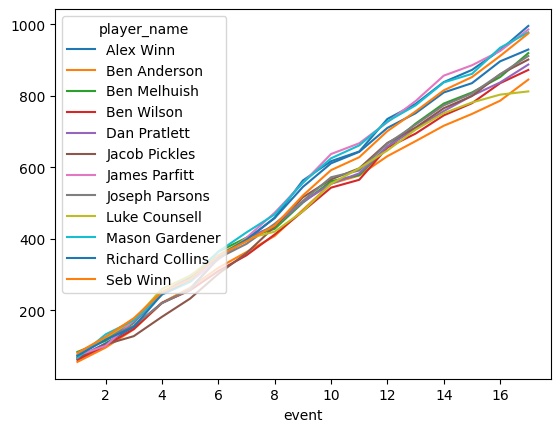

In [7]:
pivot_amagw_df = all_managers_all_gws_df.pivot_table(
    values="total_points", index="event", columns="player_name"
)
pivot_amagw_df.plot()